# Introduction


Pattern recognition and image classification has surprisingly become one of the efficient methods of malware detection/classification. Back in 2011, the researchers from University of California (Santa Barbara, California, USA) - L. Nataraj, S. Karthikeyan, G. Jacob, and B. S. Manjunath - proposed a simple yet effective method for visualizing and classifying malware using image processing techniques. Malware binaries can be visualized as gray-scale images, with the observation that for many malware families, the images belonging to the same family appear very similar in layout and texture. Motivated by this visual similarity, a classification method using standard image features had been proposed by the researcher team. Neither disassembly nor code execution is required for such a classification. Preliminary experimental results were quite promising with 98% classification accuracy on a malware database of 9,458 samples with 25 different malware families (see their public paper per https://vision.ece.ucsb.edu/sites/default/files/publications/nataraj_vizsec_2011_paper.pdf for more info).


The purpose of this notebook is to demonstrate that the hybrid **CoatNet** DL model architecture can bring more accurate malware detection/classification results on MalImg dataset, compared to the results of original inventors of Malware visualizing and classifying method mentioned above.


**Notes:**

- CoatNet implementation reused from
https://github.com/leondgarse/keras_cv_attention_models/tree/main/keras_cv_attention_models/coatnet
- Data preprocessing and brief EDA inspired by https://www.kaggle.com/code/tiletisaitejareddy/malware-classification-ism



In [1]:
#setup
import sys
import os
from math import log
import numpy as np
import pandas as pd
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback,ReduceLROnPlateau,EarlyStopping


2024-07-04 10:39:28.476572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 10:39:28.476616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 10:39:28.477399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 10:39:28.482691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Preprocessing and Basic EDA

In [2]:
# prepare the data

train_root_path = "../../Smartbin/Dataset/Crawl_dataset/Data_real"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=train_root_path, target_size=(56,56) ,batch_size=20050)

Found 19683 images belonging to 3 classes.


In [3]:
batches.class_indices

{'Organic': 0, 'Recycle': 1, 'UnRecycle': 2}

In [5]:
imgs, labels = next(batches)
imgs.shape

(19683, 56, 56, 3)

In [6]:
labels.shape

(19683, 3)

In [7]:
# # plots images with labels within jupyter notebook
# def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
#     if type(ims[0]) is np.ndarray:
#         ims = np.array(ims).astype(np.uint8)
#         if (ims.shape[-1] != 3):
#             ims = ims.transpose((0,2,3,1))
#     f = plt.figure(figsize=figsize)
#     cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
#     for i in range(0,50):
#         sp = f.add_subplot(rows, cols, i+1)
#         sp.axis('Off')
#         if titles is not None:
#             sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
#         plt.imshow(ims[i], interpolation=None if interp else 'none')

In [8]:
# plots(imgs, titles = labels)

<BarContainer object of 3 artists>

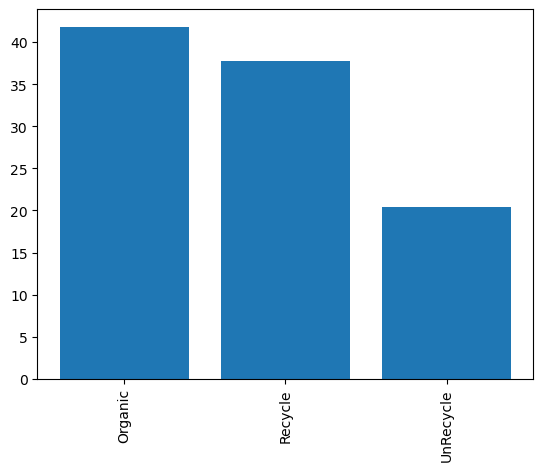

In [9]:
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.2)

In [11]:
x_train.shape

(15746, 56, 56, 3)

In [12]:
y_test.shape

(3937, 3)

In [13]:
num_classes = len(classes)
# we do not need to apply one-hot encoding to the labels as in https://keras.io/examples/vision/swin_transformers/
# since the dataset data is already prepared for the multi-class classification
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (15746, 56, 56, 3) - y_train shape: (15746, 3)
x_test shape: (3937, 56, 56, 3) - y_test shape: (3937, 3)


# CoatNet Model

**CoAtNet** is a hybrid neural network architecture where the best of CNN and Attention-based transformer models is conjugated in a single model architecture. It has been invented Zihang Dai, Hanxiao Liu, Quoc V. Le, and Mingxing Tan from Google Research team (their inventions published in https://arxiv.org/pdf/2106.04803.pdf).

Transformers have attracted increasing interests in computer vision/image pattern recognition. However, they still fall behind the state-of-the-art convolutional networks. 

The authors of **CoAtNet** demonstrated that while Transformers tend to have larger model capacity, their generalization can be worse than convolutional networks due to the lack of the right inductive bias. To effectively combine the strengths from both architectures, they invented CoAtNets, a family of hybrid models built from two key insights: 

- (1) depthwise Convolution and self-Attention can be naturally unified via simple relative attention. 
- (2) vertically stacking convolution layers and attention layers in a principled way is surprisingly effective in improving generalization, capacity and efficiency.

In the scope of this case study, the implementation of CoatNet from *Keras_cv_attention_models* Python package (per https://github.com/leondgarse/keras_cv_attention_models/tree/main/keras_cv_attention_models/convnext) has been used.

In [14]:
!pip install keras_cv_attention_models

/opt/tljh/user/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable


In [15]:
from keras_cv_attention_models import coatnet
# requires 
input_shape=(56,56,3)  # (64,64,3) 
num_epochs = 200

batch_size = 32 # 128

learning_rate = 1e-4

num_epochs = 200
validation_split = 0.175
weight_decay = 0.0001
label_smoothing = 0.1


In [16]:
base_model = coatnet.CoAtNet0(
    input_shape=input_shape, 
    num_classes=1000,  # Use 1000 to load the pre-trained weights
    drop_connect_rate=0.2,
    classifier_activation=None)  # No activation for the base model

# Add a new final layer for your specific number of classes
x = base_model.output
x = Dense(num_classes, activation='softmax', name='custom_predictions')(x)  # Ensure unique name
model = Model(inputs=base_model.input, outputs=x)

# Load pre-trained weights, ignoring the final layer
model.load_weights('/home/jupyter-iec_smartbin/.keras/models/coatnet0_224_imagenet.h5', by_name=True, skip_mismatch=True)


2024-07-04 10:42:23.980541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-04 10:42:23.980817: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-04 10:42:24.035873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

>>>> Load pretrained from: /home/jupyter-iec_smartbin/.keras/models/coatnet0_160_imagenet.h5
>>>> Reload mismatched weights: 160 -> (56, 56)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb


In [17]:
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, min_lr=1e-6)

import time

class TimeHistory(Callback):
  def on_train_begin(self, logs=None):
    self.times = []
    self.epoch_start_time = time.time()  
  def on_epoch_end(self, epoch, logs=None):
    self.times.append(time.time() - self.epoch_start_time)
    self.epoch_start_time = time.time()
      
time_callback = TimeHistory()

model_fit = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    validation_split=validation_split,
    verbose =1,
    callbacks=[early_stop,lr_reduction, time_callback]
)

Epoch 1/200


2024-07-04 10:42:34.115456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/stack_1_block_2_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-04 10:42:35.320017: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-04 10:42:36.720121: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f33999ce560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-04 10:42:36.720146: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-07-04 10:42:36.720152: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-07-04 10:42:36.725473: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling M

406/406 [==============================] - 40s 51ms/step - loss: 0.7106 - accuracy: 0.8269 - val_loss: 0.4921 - val_accuracy: 0.9024 - lr: 1.0000e-04
Epoch 2/200
406/406 [==============================] - 19s 47ms/step - loss: 0.4513 - accuracy: 0.9273 - val_loss: 0.4071 - val_accuracy: 0.9481 - lr: 1.0000e-04
Epoch 3/200
406/406 [==============================] - 19s 47ms/step - loss: 0.3920 - accuracy: 0.9591 - val_loss: 0.3951 - val_accuracy: 0.9543 - lr: 1.0000e-04
Epoch 4/200
406/406 [==============================] - 19s 47ms/step - loss: 0.3628 - accuracy: 0.9741 - val_loss: 0.4006 - val_accuracy: 0.9532 - lr: 1.0000e-04
Epoch 5/200
406/406 [==============================] - 19s 47ms/step - loss: 0.3476 - accuracy: 0.9787 - val_loss: 0.3887 - val_accuracy: 0.9565 - lr: 1.0000e-04
Epoch 6/200
406/406 [==============================] - 19s 48ms/step - loss: 0.3409 - accuracy: 0.9819 - val_loss: 0.3749 - val_accuracy: 0.9597 - lr: 1.0000e-04
Epoch 7/200
406/406 [===================

In [18]:
total_training_time = sum(time_callback.times)
print("Total training time:", total_training_time, "seconds")

Total training time: 2345.193062067032 seconds


In [19]:
model.evaluate(x_test,  y_test)

124/124 [==============================] - 2s 14ms/step - loss: 0.3608 - accuracy: 0.9703


[0.3608221411705017, 0.9702819585800171]

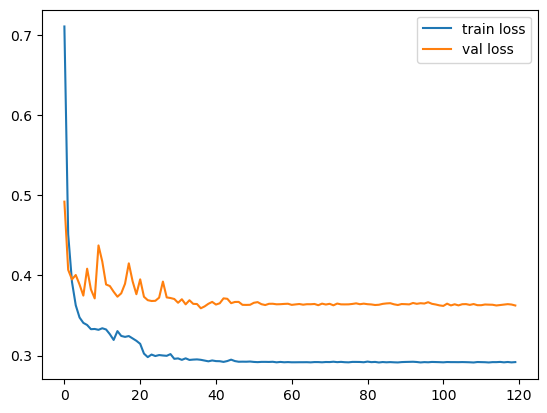

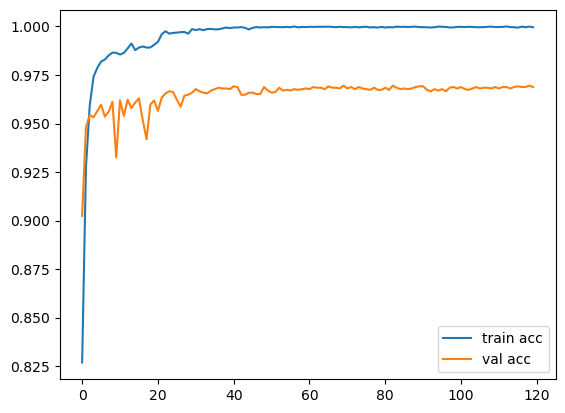

In [20]:
# plot the loss
plt.plot(model_fit.history['loss'], label='train loss')
plt.plot(model_fit.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('Swin_LossVal_loss.jpg',format='jpg')

plt.close()
# plot the accuracy
plt.plot(model_fit.history['accuracy'], label='train acc')
plt.plot(model_fit.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('Swin_AccVal_acc.jpg',format="jpg")

plt.close()

# Make predictions

In [22]:
pred_x = model.predict(x_test, verbose=0) 
y_pred=np.argmax(pred_x,axis=1)
y_pred

array([0, 1, 1, ..., 1, 2, 2])

In [23]:
y_test2 = np.argmax(y_test, axis=1)
y_test2

array([0, 1, 1, ..., 1, 2, 2])

In [85]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [86]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

NameError: name 'confusion_matrix' is not defined

In [24]:
from sklearn import metrics
# Print the precision and recall, among other metrics
report =  metrics.classification_report(y_test2, y_pred, digits=3, output_dict=True)

df = pd.DataFrame(report).transpose().reset_index()
df = df.rename(columns={"index": "class_label"})


Let's review the part of the classification report related to each individual class

In [29]:
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.975316,0.979444,0.977376,1654.000000
1,0.965350,0.964014,0.964681,1445.000000
2,0.968788,0.963007,0.965889,838.000000
accuracy,0.970282,0.970282,0.970282,0.970282
macro avg,0.969818,0.968822,0.969315,3937.000000
weighted avg,0.970269,0.970282,0.970271,3937.000000


In [25]:
clf_rep = metrics.precision_recall_fscore_support(y_test2, y_pred)
out_dict = {
             "precision" : clf_rep[0].round(3)
            ,"recall" : clf_rep[1].round(3)
            ,"f1-score" : clf_rep[2].round(3)
            ,"support" : clf_rep[3]
            }
out_df = pd.DataFrame(out_dict).reset_index().rename(columns={"index": "class_label"})
class_label_values = dict(zip(range(0,len(batches.class_indices)), batches.class_indices))
out_df['class_label'] = out_df['class_label'].map(class_label_values)
out_df

,class_label,precision,recall,f1-score,support
0,Organic,0.975,0.979,0.977,1654
1,Recycle,0.965,0.964,0.965,1445
2,UnRecycle,0.969,0.963,0.966,838


Now let's review the aggregated values from  the classification report

In [ ]:
# display aggregated values - selecting rows based on condition 
options = ['accuracy', 'macro avg',  'weighted avg']
agg_df = df[df['class_label'].isin(options)]
agg_df